## Import

In [1002]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
from tqdm import tqdm
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost as xgb
from catboost import CatBoostClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from imblearn.over_sampling import SMOTE
from functools import cache

tqdm.pandas()

In [22]:
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
import pandas as pd


def expected_calibration_error(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    bin_totals = np.histogram(y_prob, bins=np.linspace(0, 1, n_bins + 1), density=False)[0]
    non_empty_bins = bin_totals > 0
    bin_weights = bin_totals / len(y_prob)
    bin_weights = bin_weights[non_empty_bins]
    prob_true = prob_true[:len(bin_weights)]
    prob_pred = prob_pred[:len(bin_weights)]
    ece = np.sum(bin_weights * np.abs(prob_true - prob_pred))
    return ece
    
def auc_brier_ece(answer_df, submission_df):
    # Check for missing values in submission_df
    if submission_df.isnull().values.any():
        raise ValueError("The submission dataframe contains missing values.")


    # Check if the number and names of columns are the same in both dataframes
    if len(answer_df.columns) != len(submission_df.columns) or not all(answer_df.columns == submission_df.columns):
        raise ValueError("The columns of the answer and submission dataframes do not match.")
        
    submission_df = submission_df[submission_df.iloc[:, 0].isin(answer_df.iloc[:, 0])]
    submission_df.index = range(submission_df.shape[0])
    
    # Calculate AUC for each class
    auc_scores = []
    for column in answer_df.columns[1:]:
        y_true = answer_df[column]
        y_scores = submission_df[column]
        auc = roc_auc_score(y_true, y_scores)
        auc_scores.append(auc)


    # Calculate mean AUC
    mean_auc = np.mean(auc_scores)


    brier_scores = []
    ece_scores = []
    
    # Calculate Brier Score and ECE for each class
    for column in answer_df.columns[1:]:
        y_true = answer_df[column].values
        y_prob = submission_df[column].values
        
        # Brier Score
        brier = mean_squared_error(y_true, y_prob)
        brier_scores.append(brier)
        
        # ECE
        ece = expected_calibration_error(y_true, y_prob)
        ece_scores.append(ece)
    
    # Calculate mean Brier Score and mean ECE
    mean_brier = np.mean(brier_scores)
    mean_ece = np.mean(ece_scores)
    
    # Calculate combined score
    combined_score = 0.5 * (1 - mean_auc) + 0.25 * mean_brier + 0.25 * mean_ece
    
    return mean_auc,mean_brier,mean_ece,combined_score

## Data Load

In [23]:
cat_fill_A = SimpleImputer(strategy='most_frequent')
cat_fill_B = SimpleImputer(strategy='most_frequent')

In [24]:
BASE_DIR = "./data"

train_meta = pd.read_csv(os.path.join(BASE_DIR, "train.csv"))
train_A = pd.read_csv(os.path.join(BASE_DIR, "train", "A.csv"), encoding="utf_8")
train_B = pd.read_csv(os.path.join(BASE_DIR, "train", "B.csv"))
train_A = pd.DataFrame(cat_fill_A.fit_transform(train_A),columns=train_A.columns)
train_B = pd.DataFrame(cat_fill_B.fit_transform(train_B),columns=train_B.columns)
# train_A.dropna(inplace=True)
# train_B.dropna(inplace=True)

print("train_meta:", train_meta.shape)
print("train_A:", train_A.shape)
print("train_B:", train_B.shape)

train_meta: (944767, 3)
train_A: (647241, 37)
train_B: (297526, 31)


In [25]:
joblib.dump(cat_fill_A, "./model/cat_fill_A.joblib")
joblib.dump(cat_fill_B, "./model/cat_fill_B.joblib")   # ★ 통째로 저장

['./model/cat_fill_B.joblib']

In [ ]:
# df_tp = pd.merge(train_B,train_meta[train_meta["Test"]=="B"])
# ad = df_tp[df_tp.isna().any(axis=1)]

In [ ]:
rows = [np.fromstring(s, sep=',', dtype=np.int8) for s in train_A["A1-3"].to_numpy()]  # 또는 np.int32
X_mask = np.vstack(rows)  # -> (N, K)
mask = X_mask.astype(bool)

In [74]:
x = seq_(train_A["A1-4"])
maksed_ = np.where(mask, x, 0).astype(float)
# maksed_ = np.abs(maksed_[maksed_ != 0])
# maksed_.sum(axis=1)/len(maksed_)

In [75]:
maksed_

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [ 639., -481.,  725., ...,    0.,  597.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.]],
      shape=(647241, 18))

In [62]:
x

array([[  29.,   33.,   56., ...,   21.,   13.,   18.],
       [  76.,    1.,   27., ...,   31.,    8.,   15.],
       [  -1.,   22.,    0., ...,   -4.,    0.,  -26.],
       ...,
       [ 639., -481.,  725., ..., -286.,  597., -242.],
       [ -28.,   -3.,  -42., ...,   21.,  -20.,   13.],
       [ -11.,   18.,   30., ...,   -4.,    8.,   -3.]],
      shape=(647241, 18))

In [76]:
abs(maksed_).sum(axis=1)

array([   0.,    0.,    0., ..., 4884.,    0.,    0.], shape=(647241,))

In [77]:
abs(maksed_).mean(axis=1)

array([  0.        ,   0.        ,   0.        , ..., 271.33333333,
         0.        ,   0.        ], shape=(647241,))

In [61]:
train_A["A1-4"]

0         29,33,56,64,5,-51,44,-1,0,31,30,5,67,33,43,21,...
1         76,1,27,25,41,34,-24,7,18,85,-18,-21,31,-7,18,...
2         -1,22,0,-37,-21,7,-34,-21,-79,-26,-80,-23,-63,...
3         -60,25,-25,-34,-40,-60,-46,-79,-77,-51,-80,-62...
4         -42,-77,-33,-3,-38,-58,-88,-4,-28,-58,-40,-29,...
                                ...                        
647236    -17,-151,-54,-6,124,-83,56,-7,10,-21,61,1,-43,...
647237    -77,5,-213,-97,-72,-97,-89,-197,-111,-146,-344...
647238    639,-481,725,-233,-342,-256,-322,-848,-294,-33...
647239    -28,-3,-42,-3,-24,8,-8,-18,-6,-77,8,-54,35,44,...
647240    -11,18,30,5,-20,-8,-62,32,-77,-77,-122,-72,67,...
Name: A1-4, Length: 647241, dtype: object

In [40]:
maksed_

array([722., 817., 343., ..., 336., 594., 597.], shape=(168313,))

In [69]:
masked_failed_rt_abs_sum_from_csv_series(train_A["A1-4"], mask)

array([0.        , 0.        , 0.        , ..., 0.00754588, 0.        ,
       0.        ], shape=(647241,))

In [ ]:
# rows = [np.fromstring(s, sep=',') for s in train_A["A1-4"].to_numpy()]  # 또는 np.int32
# X = np.vstack(rows)  # -> (N, K)
# Y = np.where(mask, X, 0).astype(float)

## Data Pre-processing

In [84]:
def convert_age(val):
    if pd.isna(val): return np.nan
    try:
        base = int(str(val)[:-1])
        return base if str(val)[-1] == "a" else base + 5
    except:
        return np.nan

def split_testdate(val):
    try:
        v = int(val)
        return v // 100, v % 100
    except:
        return np.nan, np.nan
    
def seq_(series):
    rows = [np.fromstring(x, sep=",") for x in series.to_numpy()]
    X = np.vstack(rows)
    return X

# rate 전체 평균
def masked_failed_mean_from_csv_series(cond_series, mask):
    x = seq_(cond_series)
    maksed_ = np.where(mask, x, 0).astype(float)
    return maksed_.mean(axis=1)

# rate 양수 평균
def masked_failed_pos_neg_mean_from_csv_series(cond_series, mask):
    x = seq_(cond_series)
    maksed_ = np.where(mask, x, 0).astype(float)
    pos = np.where(maksed_ > 0,maksed_, 0).mean(axis=1)
    neg = np.where(maksed_ < 0,maksed_, 0).mean(axis=1)
    return pos, neg

# rate max치
def masked_failed_rt_max_from_csv_series(cond_series, mask):
    x = seq_(cond_series)
    maksed_ = np.where(mask, x, 0).astype(float)
    max_ = maksed_.max(axis=1)
    min_ = maksed_.min(axis=1)
    return max_, min_

# rate 절대평군
def masked_failed_rt_abs_mean_from_csv_series(cond_series, mask):
    x = seq_(cond_series)
    maksed_ = np.where(mask, x, 0).astype(float)
    return abs(maksed_).mean(axis=1)

# rate 절대합
def masked_failed_rt_abs_sum_from_csv_series(cond_series, mask):
    x = seq_(cond_series)
    maksed_ = np.where(mask, x, 0).astype(float)
    return abs(maksed_).sum(axis=1)


def masked_failed_sum_from_csv_series(cond_series, mask,target_num):
    x = seq_(cond_series)
    maksed_ = np.where(mask, x, 0).astype(float)
    return np.where(maksed_ == target_num, maksed_, 0).sum(axis=1)/target_num
    

def seq_mean(series):
    return series.fillna("").progress_apply(
        lambda x: np.fromstring(x, sep=",").mean() if x else np.nan
    )

def seq_std(series):
    return series.fillna("").progress_apply(
        lambda x: np.fromstring(x, sep=",").std() if x else np.nan
    )

def seq_rate(series, target="1"):
    return series.fillna("").progress_apply(
        lambda x: str(x).split(",").count(target) / len(x.split(",")) if x else np.nan
    )

def masked_mean_from_csv_series(cond_series, val_series, mask_val):
    cond_df = cond_series.fillna("").str.split(",", expand=True).replace("", np.nan)
    val_df  = val_series.fillna("").str.split(",", expand=True).replace("", np.nan)

    cond_arr = cond_df.to_numpy(dtype=float)
    val_arr  = val_df.to_numpy(dtype=float)

    mask = (cond_arr == mask_val)
    with np.errstate(invalid="ignore"):
        sums = np.nansum(np.where(mask, val_arr, np.nan), axis=1)
        counts = np.sum(mask, axis=1)
        out = sums / np.where(counts==0, np.nan, counts)
    return pd.Series(out, index=cond_series.index)

def masked_mean_in_set_series(cond_series, val_series, mask_set):
    cond_df = cond_series.fillna("").str.split(",", expand=True).replace("", np.nan)
    val_df  = val_series.fillna("").str.split(",", expand=True).replace("", np.nan)

    cond_arr = cond_df.to_numpy(dtype=float)
    val_arr  = val_df.to_numpy(dtype=float)

    mask = np.isin(cond_arr, list(mask_set))
    with np.errstate(invalid="ignore"):
        sums = np.nansum(np.where(mask, val_arr, np.nan), axis=1)
        counts = np.sum(mask, axis=1)
        out = sums / np.where(counts == 0, np.nan, counts)
    return pd.Series(out, index=cond_series.index)

In [79]:
qqqqq = np.arange(-6,12).reshape(6,3)

In [80]:
np.where(qqqqq > 0,qqqqq,0)

array([[ 0,  0,  0],
       [ 0,  0,  0],
       [ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [81]:
qqqqq.max()-qqqqq.min()

np.int64(17)

In [82]:
qqqqq.max()

np.int64(11)

In [31]:
train_A["A4-1"]

0         2,2,2,1,2,2,1,2,2,1,2,1,1,1,2,1,2,1,1,1,2,1,2,...
1         2,1,1,1,2,1,1,2,1,1,1,2,2,1,2,1,2,2,2,2,1,2,2,...
2         1,1,2,1,1,1,1,2,1,2,2,1,1,1,2,2,2,2,2,1,2,1,2,...
3         2,2,2,2,1,1,2,1,1,2,2,1,1,2,2,1,2,1,2,1,2,1,2,...
4         1,2,2,2,2,2,1,1,2,2,1,1,1,2,1,1,2,2,2,1,1,1,1,...
                                ...                        
647236    2,1,2,1,2,1,2,2,1,1,1,2,2,1,1,2,1,2,2,1,1,2,1,...
647237    2,2,1,1,1,1,1,1,2,1,1,2,1,2,1,2,1,1,2,1,2,1,2,...
647238    1,1,2,1,2,2,2,2,1,1,2,2,2,1,2,1,2,1,2,1,1,2,2,...
647239    1,1,1,2,1,2,1,2,2,1,2,2,1,1,2,2,2,2,2,1,2,2,2,...
647240    2,1,1,1,1,2,2,2,1,1,1,1,1,1,1,1,1,2,1,1,2,2,2,...
Name: A4-1, Length: 647241, dtype: object

## 1차 Feature Engineering

In [85]:
def preprocess_A(train_A):
    df = train_A.copy()
    
    # ---- Age, TestDate 파생 ----
    print("Step 1: Age, TestDate 파생...")
    df["Age_num"] = df["Age"].map(convert_age)
    ym = df["TestDate"].map(split_testdate)
    df["Year"] = [y for y, m in ym]
    df["Month"] = [m for y, m in ym]

    feats = pd.DataFrame(index=df.index)

    # ---- A1 ----
    print("Step 2: A1 feature 생성...")
    feats["A1_resp_rate"] = seq_rate(df["A1-3"], "1")
    feats["A1_rt_mean"]   = seq_mean(df["A1-4"])
    feats["A1_rt_std"]    = seq_std(df["A1-4"])
    
    mask = seq_(df["A1-3"]).astype(bool)
    
    feats["A1-1_failed_count_1"] = masked_failed_sum_from_csv_series(df["A1-1"], mask, 1)
    feats["A1-1_failed_count_2"] = masked_failed_sum_from_csv_series(df["A1-1"], mask, 2)
    feats["A1-1_failed_sum"] = feats["A1-1_failed_count_1"]+feats["A1-1_failed_count_2"]
    
    feats["A1-2_failed_count_1"] = masked_failed_sum_from_csv_series(df["A1-2"], mask, 1)
    feats["A1-2_failed_count_2"] = masked_failed_sum_from_csv_series(df["A1-2"], mask, 2)
    feats["A1-2_failed_count_3"] = masked_failed_sum_from_csv_series(df["A1-2"], mask, 3)
    feats["A1-2_failed_sum"] = feats["A1-2_failed_count_1"]+feats["A1-2_failed_count_2"]+feats["A1-2_failed_count_3"]
    
    feats["A1-fail_rt_mean"] = masked_failed_mean_from_csv_series(df["A1-4"], mask)
    feats["A1-fail_rt_pos_mean"], feats["A1-fail_rt_neg_mean"] = masked_failed_pos_neg_mean_from_csv_series(df["A1-4"], mask)
    feats["A1-fail_rt_max"], feats["A1-fail_rt_min"] = masked_failed_rt_max_from_csv_series(df["A1-4"], mask)
    feats["A1-fail_rt_abs_mean"] = masked_failed_rt_abs_mean_from_csv_series(df["A1-4"], mask)
    feats["A1-fail_rt_abs_sum"] = masked_failed_rt_abs_sum_from_csv_series(df["A1-4"], mask)
    
    feats["A1-fail_rt_minmax_distance"] = feats["A1-fail_rt_max"] - feats["A1-fail_rt_min"]
    
    feats["A1_rt_left"]   = masked_mean_from_csv_series(df["A1-1"], df["A1-4"], 1)
    feats["A1_rt_right"]  = masked_mean_from_csv_series(df["A1-1"], df["A1-4"], 2)
    feats["A1_rt_side_diff"] = feats["A1_rt_left"] - feats["A1_rt_right"]
    feats["A1_rt_slow"]   = masked_mean_from_csv_series(df["A1-2"], df["A1-4"], 1)
    feats["A1_rt_normal"]   = masked_mean_from_csv_series(df["A1-2"], df["A1-4"], 2)
    feats["A1_rt_fast"]   = masked_mean_from_csv_series(df["A1-2"], df["A1-4"], 3)
    feats["A1_rt_speed_diff"] = feats["A1_rt_slow"] - feats["A1_rt_fast"]

    # ---- A2 ----
    print("Step 3: A2 feature 생성...")
    feats["A2_resp_rate"] = seq_rate(df["A2-3"], "1")
    feats["A2_rt_mean"]   = seq_mean(df["A2-4"])
    feats["A2_rt_std"]    = seq_std(df["A2-4"])
    
    mask = seq_(df["A2-3"]).astype(bool)
    
    feats["A2-1_failed_count_1"] = masked_failed_sum_from_csv_series(df["A2-1"], mask, 1)
    feats["A2-1_failed_count_2"] = masked_failed_sum_from_csv_series(df["A2-1"], mask, 2)
    feats["A2-1_failed_count_3"] = masked_failed_sum_from_csv_series(df["A2-1"], mask, 3)
    feats["A2-1_failed_sum"] = feats["A2-1_failed_count_1"]+feats["A2-1_failed_count_2"]+feats["A2-1_failed_count_3"]
    
    feats["A2-2_failed_count_1"] = masked_failed_sum_from_csv_series(df["A2-2"], mask, 1)
    feats["A2-2_failed_count_2"] = masked_failed_sum_from_csv_series(df["A2-2"], mask, 2)
    feats["A2-2_failed_count_3"] = masked_failed_sum_from_csv_series(df["A2-2"], mask, 3)
    feats["A2-2_failed_sum"] = feats["A2-2_failed_count_1"]+feats["A2-2_failed_count_2"]+feats["A2-2_failed_count_3"]
    
    feats["A2-fail_rt_mean"] = masked_failed_mean_from_csv_series(df["A2-4"], mask)
    feats["A2-fail_rt_pos_mean"], feats["A2-fail_rt_neg_mean"] = masked_failed_pos_neg_mean_from_csv_series(df["A2-4"], mask)
    feats["A2-fail_rt_max"], feats["A2-fail_rt_min"] = masked_failed_rt_max_from_csv_series(df["A2-4"], mask)
    feats["A2-fail_rt_abs_mean"] = masked_failed_rt_abs_mean_from_csv_series(df["A2-4"], mask)
    feats["A2-fail_rt_abs_sum"] = masked_failed_rt_abs_sum_from_csv_series(df["A2-4"], mask)
    feats["A2-fail_rt_minmax_distance"] = feats["A2-fail_rt_max"] - feats["A2-fail_rt_min"]
    
    feats["A2-fail_rt_mean"] = masked_failed_mean_from_csv_series(df["A2-4"], mask)
    
    feats["A2_rt_cond1_diff"] = masked_mean_from_csv_series(df["A2-1"], df["A2-4"], 1) - \
                                masked_mean_from_csv_series(df["A2-1"], df["A2-4"], 3)
    feats["A2_rt_cond2_diff"] = masked_mean_from_csv_series(df["A2-2"], df["A2-4"], 1) - \
                                masked_mean_from_csv_series(df["A2-2"], df["A2-4"], 3)

    # ---- A3 ----
    print("Step 4: A3 feature 생성...")
    s = df["A3-5"].fillna("")
    total   = s.apply(lambda x: len(x.split(",")) if x else 0)
    valid   = s.apply(lambda x: sum(v in {"1","2"} for v in x.split(",")) if x else 0)
    invalid = s.apply(lambda x: sum(v in {"3","4"} for v in x.split(",")) if x else 0)
    correct = s.apply(lambda x: sum(v in {"1","3"} for v in x.split(",")) if x else 0)
    feats["A3_valid_ratio"]   = (valid / total).replace([np.inf,-np.inf], np.nan)
    feats["A3_invalid_ratio"] = (invalid / total).replace([np.inf,-np.inf], np.nan)
    feats["A3_correct_ratio"] = (correct / total).replace([np.inf,-np.inf], np.nan)
    
    mask = seq_(df["A3-6"]).astype(bool)

    feats["A3-1_failed_count_1"] = masked_failed_sum_from_csv_series(df["A3-1"], mask, 1)
    feats["A3-1_failed_count_2"] = masked_failed_sum_from_csv_series(df["A3-1"], mask, 2)
    feats["A3-1_failed_sum"] = feats["A3-1_failed_count_1"]+feats["A3-1_failed_count_2"]
    
    print("A3-2_failed_count start")
    
    feats["A3-2_failed_sum"] = 0
    for i in range(1,9):
        feats[f"A3-2_failed_count_{i}"] = masked_failed_sum_from_csv_series(df["A3-2"], mask, i)
        feats["A3-2_failed_sum"] += feats[f"A3-2_failed_count_{i}"]
        
    feats["A3-3_failed_count_1"] = masked_failed_sum_from_csv_series(df["A3-3"], mask, 1)
    feats["A3-3_failed_count_2"] = masked_failed_sum_from_csv_series(df["A3-3"], mask, 2)
    feats["A3-3_failed_sum"] = feats["A3-3_failed_count_1"]+feats["A3-3_failed_count_2"]
    
    feats["A3-4_failed_sum"] = 0
    for i in range(1,9):
        feats[f"A3-4_failed_count_{i}"] = masked_failed_sum_from_csv_series(df["A3-4"], mask, i)
        feats["A3-4_failed_sum"] += feats[f"A3-4_failed_count_{i}"]
        
    feats["A3-5_failed_sum"] = 0
    for i in range(1,5):
        feats[f"A3-5_failed_count_{i}"] = masked_failed_sum_from_csv_series(df["A3-5"], mask, i)
        feats["A3-5_failed_sum"] += feats[f"A3-5_failed_count_{i}"]
    
    feats["A3-fail_rt_mean"] = masked_failed_mean_from_csv_series(df["A3-7"], mask)
    
    feats["A3-fail_rt_mean"] = masked_failed_mean_from_csv_series(df["A3-7"], mask)
    feats["A3-fail_rt_pos_mean"], feats["A3-fail_rt_neg_mean"] = masked_failed_pos_neg_mean_from_csv_series(df["A3-7"], mask)
    feats["A3-fail_rt_max"], feats["A3-fail_rt_min"] = masked_failed_rt_max_from_csv_series(df["A3-7"], mask)
    feats["A3-fail_rt_abs_mean"] = masked_failed_rt_abs_mean_from_csv_series(df["A3-7"], mask)
    feats["A3-fail_rt_abs_sum"] = masked_failed_rt_abs_sum_from_csv_series(df["A3-7"], mask)
    feats["A3-fail_rt_minmax_distance"] = feats["A3-fail_rt_max"] - feats["A3-fail_rt_min"]
    
    feats["A3_resp2_rate"] = seq_rate(df["A3-6"], "1")
    feats["A3_rt_mean"]    = seq_mean(df["A3-7"])
    feats["A3_rt_std"]     = seq_std(df["A3-7"])
    feats["A3_rt_size_diff"] = masked_mean_from_csv_series(df["A3-1"], df["A3-7"], 1) - \
                               masked_mean_from_csv_series(df["A3-1"], df["A3-7"], 2)
    feats["A3_rt_side_diff"] = masked_mean_from_csv_series(df["A3-3"], df["A3-7"], 1) - \
                               masked_mean_from_csv_series(df["A3-3"], df["A3-7"], 2)

    # ---- A4 ----
    print("Step 5: A4 feature 생성...")
    feats["A4_acc_rate"]   = seq_rate(df["A4-3"], "1")
    feats["A4_resp2_rate"] = seq_rate(df["A4-4"], "1")
    feats["A4_rt_mean"]    = seq_mean(df["A4-5"])
    feats["A4_rt_std"]     = seq_std(df["A4-5"])
    
    mask = seq_(df["A4-4"]).astype(bool)
    
    feats["A4-1_failed_count_1"] = masked_failed_sum_from_csv_series(df["A4-1"], mask, 1)
    feats["A4-1_failed_count_2"] = masked_failed_sum_from_csv_series(df["A4-1"], mask, 2)
    feats["A4-1_failed_sum"] = feats["A4-1_failed_count_1"]+feats["A4-1_failed_count_2"]
    
    feats["A4-2_failed_count_1"] = masked_failed_sum_from_csv_series(df["A4-2"], mask, 1)
    feats["A4-2_failed_count_2"] = masked_failed_sum_from_csv_series(df["A4-2"], mask, 2)
    feats["A4-2_failed_sum"] = feats["A4-2_failed_count_1"]+feats["A4-2_failed_count_2"]
        
    feats["A4-3_failed_count_1"] = masked_failed_sum_from_csv_series(df["A4-3"], mask, 1)
    feats["A4-3_failed_count_2"] = masked_failed_sum_from_csv_series(df["A4-3"], mask, 2)
    feats["A4-3_failed_sum"] = feats["A4-3_failed_count_1"]+feats["A4-3_failed_count_2"]
    
    feats["A4-fail_rt_mean"] = masked_failed_mean_from_csv_series(df["A4-5"], mask)
    feats["A4-fail_rt_pos_mean"], feats["A4-fail_rt_neg_mean"] = masked_failed_pos_neg_mean_from_csv_series(df["A4-5"], mask)
    feats["A4-fail_rt_max"], feats["A4-fail_rt_min"] = masked_failed_rt_max_from_csv_series(df["A4-5"], mask)
    feats["A4-fail_rt_abs_mean"] = masked_failed_rt_abs_mean_from_csv_series(df["A4-5"], mask)
    feats["A4-fail_rt_abs_sum"] = masked_failed_rt_abs_sum_from_csv_series(df["A4-5"], mask)
    feats["A4-fail_rt_minmax_distance"] = feats["A4-fail_rt_max"] - feats["A4-fail_rt_min"]
    
    
    feats["A4-fail_rt_mean"] = masked_failed_mean_from_csv_series(df["A4-5"], mask)
    
    feats["A4_stroop_diff"] = masked_mean_from_csv_series(df["A4-1"], df["A4-5"], 2) - \
                              masked_mean_from_csv_series(df["A4-1"], df["A4-5"], 1)
    feats["A4_rt_color_diff"] = masked_mean_from_csv_series(df["A4-2"], df["A4-5"], 1) - \
                                masked_mean_from_csv_series(df["A4-2"], df["A4-5"], 2)

    # ---- A5 ----
    print("Step 6: A5 feature 생성...")
    feats["A5_acc_rate"]   = seq_rate(df["A5-2"], "1")
    feats["A5_resp2_rate"] = seq_rate(df["A5-3"], "1")
    
    mask = seq_(df["A5-3"]).astype(bool)
    
    feats["A5-1_failed_sum"] = 0
    for i in range(1,5):
        feats[f"A5-1_failed_count_{i}"] = masked_failed_sum_from_csv_series(df["A5-1"], mask, i)
        feats["A5-1_failed_sum"] += feats[f"A5-1_failed_count_{i}"]
        
    feats["A5-2_failed_count_1"] = masked_failed_sum_from_csv_series(df["A5-2"], mask, 1)
    feats["A5-2_failed_count_2"] = masked_failed_sum_from_csv_series(df["A5-2"], mask, 2)
    feats["A5-2_failed_sum"] = feats["A5-2_failed_count_1"]+feats["A5-2_failed_count_2"]
    
    feats["A5_acc_nonchange"] = masked_mean_from_csv_series(df["A5-1"], df["A5-2"], 1)
    feats["A5_acc_change"]    = masked_mean_in_set_series(df["A5-1"], df["A5-2"], {2,3,4})

    # ---- Drop ----
    print("Step 7: 시퀀스 컬럼 drop & concat...")
    seq_cols = [
        "A1-1","A1-2","A1-3","A1-4",
        "A2-1","A2-2","A2-3","A2-4",
        "A3-1","A3-2","A3-3","A3-4","A3-5","A3-6","A3-7",
        "A4-1","A4-2","A4-3","A4-4","A4-5",
        "A5-1","A5-2","A5-3"
    ]
    print("A 검사 데이터 전처리 완료")
    return pd.concat([df.drop(columns=seq_cols, errors="ignore"), feats], axis=1)

In [89]:
def preprocess_B(train_B):
    df = train_B.copy()

    # ---- Age, TestDate ----
    print("Step 1: Age, TestDate 파생...")
    df["Age_num"] = df["Age"].map(convert_age)
    ym = df["TestDate"].map(split_testdate)
    df["Year"] = [y for y, m in ym]
    df["Month"] = [m for y, m in ym]

    feats = pd.DataFrame(index=df.index)

    # ---- B1 ----
    print("Step 2: B1 feature 생성...")
    feats["B1_acc_task1"] = seq_rate(df["B1-1"], "1")
    feats["B1_rt_mean"]   = seq_mean(df["B1-2"])
    feats["B1_rt_std"]    = seq_std(df["B1-2"])
    
    mask = (seq_(df["B1-1"]) - 1).astype(bool)
    
    feats["B1-fail_rt_mean"] = masked_failed_mean_from_csv_series(df["B1-2"], mask) 
    feats["B1_fail_rt_pos_mean"], feats["B1_fail_rt_neg_mean"] = masked_failed_pos_neg_mean_from_csv_series(df["B1-2"], mask)
    feats["B1_fail_rt_max"], feats["B1_fail_rt_min"] = masked_failed_rt_max_from_csv_series(df["B1-2"], mask)
    feats["B1-fail_rt_abs_mean"] = masked_failed_rt_abs_mean_from_csv_series(df["B1-2"], mask)
    feats["B1-fail_rt_abs_sum"] = masked_failed_rt_abs_sum_from_csv_series(df["B1-2"], mask)
    feats["B1-fail_rt_minmax_distance"] = feats["B1_fail_rt_max"] - feats["B1_fail_rt_min"]
    
    feats["B1-3_failed_sum"] = 0
    for i in range(1,5):
        feats[f"B1-3_failed_count_{i}"] = masked_failed_sum_from_csv_series(df["B1-3"], mask, i)
        feats["B1-3_failed_sum"] += feats[f"B1-3_failed_count_{i}"]
    
    feats["B1_acc_task2"] = seq_rate(df["B1-3"], "1")

    # ---- B2 ----
    print("Step 3: B2 feature 생성...")
    feats["B2_acc_task1"] = seq_rate(df["B2-1"], "1")
    feats["B2_rt_mean"]   = seq_mean(df["B2-2"])
    feats["B2_rt_std"]    = seq_std(df["B2-2"])
    
    mask = (seq_(df["B2-1"]) - 1).astype(bool)
    
    feats["B2-fail_rt_mean"] = masked_failed_mean_from_csv_series(df["B2-2"], mask)
    feats["B2_fail_rt_pos_mean"], feats["B2_fail_rt_neg_mean"] = masked_failed_pos_neg_mean_from_csv_series(df["B2-2"], mask)
    feats["B2_fail_rt_max"], feats["B2_fail_rt_min"] = masked_failed_rt_max_from_csv_series(df["B2-2"], mask)
    feats["B2-fail_rt_abs_mean"] = masked_failed_rt_abs_mean_from_csv_series(df["B2-2"], mask)
    feats["B2-fail_rt_abs_sum"] = masked_failed_rt_abs_sum_from_csv_series(df["B2-2"], mask)
    feats["B2-fail_rt_minmax_distance"] = feats["B2_fail_rt_max"] - feats["B2_fail_rt_min"]
    
    feats["B2-3_failed_sum"] = 0
    for i in range(1,5):
        feats[f"B2-3_failed_count_{i}"] = masked_failed_sum_from_csv_series(df["B2-3"], mask, i)
        feats["B2-3_failed_sum"] += feats[f"B2-3_failed_count_{i}"]
    
    feats["B2_acc_task2"] = seq_rate(df["B2-3"], "1")

    # ---- B3 ----
    print("Step 4: B3 feature 생성...")
    feats["B3_acc_rate"] = seq_rate(df["B3-1"], "1")
    feats["B3_rt_mean"]  = seq_mean(df["B3-2"])
    feats["B3_rt_std"]   = seq_std(df["B3-2"])
    
    mask = (seq_(df["B3-1"]) - 1).astype(bool)
    
    feats["B3-fail_rt_mean"] = masked_failed_mean_from_csv_series(df["B3-2"], mask)
    feats["B3_fail_rt_pos_mean"], feats["B3_fail_rt_neg_mean"] = masked_failed_pos_neg_mean_from_csv_series(df["B3-2"], mask)
    feats["B3_fail_rt_max"], feats["B3_fail_rt_min"] = masked_failed_rt_max_from_csv_series(df["B3-2"], mask)
    feats["B3-fail_rt_abs_mean"] = masked_failed_rt_abs_mean_from_csv_series(df["B3-2"], mask)
    feats["B3-fail_rt_abs_sum"] = masked_failed_rt_abs_sum_from_csv_series(df["B3-2"], mask)
    feats["B3-fail_rt_minmax_distance"] = feats["B3_fail_rt_max"] - feats["B3_fail_rt_min"]

    # ---- B4 ----
    print("Step 5: B4 feature 생성...")
    feats["B4_acc_rate"] = seq_rate(df["B4-1"], "1")
    feats["B4_rt_mean"]  = seq_mean(df["B4-2"])
    feats["B4_rt_std"]   = seq_std(df["B4-2"])

    # ---- B5 ----
    print("Step 6: B5 feature 생성...")
    feats["B5_acc_rate"] = seq_rate(df["B5-1"], "1")
    feats["B5_rt_mean"]  = seq_mean(df["B5-2"])
    feats["B5_rt_std"]   = seq_std(df["B5-2"])
    
    mask = (seq_(df["B5-1"]) - 1).astype(bool)
    
    feats["B5-fail_rt_mean"] = masked_failed_mean_from_csv_series(df["B5-2"], mask)
    feats["B5_fail_rt_pos_mean"], feats["B5_fail_rt_neg_mean"] = masked_failed_pos_neg_mean_from_csv_series(df["B5-2"], mask)
    feats["B5_fail_rt_max"], feats["B5_fail_rt_min"] = masked_failed_rt_max_from_csv_series(df["B5-2"], mask)
    feats["B5-fail_rt_abs_mean"] = masked_failed_rt_abs_mean_from_csv_series(df["B5-2"], mask)
    feats["B5-fail_rt_abs_sum"] = masked_failed_rt_abs_sum_from_csv_series(df["B5-2"], mask)
    feats["B5-fail_rt_minmax_distance"] = feats["B5_fail_rt_max"] - feats["B5_fail_rt_min"]
    
    # ---- B6~B8 ----
    print("Step 7: B6~B8 feature 생성...")
    feats["B6_acc_rate"] = seq_rate(df["B6"], "1")
    feats["B7_acc_rate"] = seq_rate(df["B7"], "1")
    feats["B8_acc_rate"] = seq_rate(df["B8"], "1")

    # ---- Drop ----
    print("Step 8: 시퀀스 컬럼 drop & concat...")
    seq_cols = [
        "B1-1","B1-2","B1-3",
        "B2-1","B2-2","B2-3",
        "B3-1","B3-2",
        "B4-1","B4-2",
        "B5-1","B5-2",
        "B6","B7","B8"
    ]

    print("B 검사 데이터 전처리 완료")
    return pd.concat([df.drop(columns=seq_cols, errors="ignore"), feats], axis=1)

In [87]:
train_A_features = preprocess_A(train_A)
train_B_features = preprocess_B(train_B)

print("A:", train_A_features.shape, "B:", train_B_features.shape)

Step 1: Age, TestDate 파생...
Step 2: A1 feature 생성...


100%|██████████| 647241/647241 [00:16<00:00, 39468.60it/s]


Step 3: A2 feature 생성...


100%|██████████| 647241/647241 [00:16<00:00, 39553.57it/s]


Step 4: A3 feature 생성...
A3-2_failed_count start


100%|██████████| 647241/647241 [00:18<00:00, 34862.24it/s]


Step 5: A4 feature 생성...


100%|██████████| 647241/647241 [00:25<00:00, 25696.66it/s]
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_20640\2896930023.py:148: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["A4-2_failed_sum"] = feats["A4-2_failed_count_1"]+feats["A4-2_failed_count_2"]
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_20640\2896930023.py:150: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["A4-3_failed_count_1"] = masked_failed_sum_from_csv_series(df["A4-3"], mask, 1)
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_20640\2896930023.py:151: Perfo

Step 6: A5 feature 생성...


100%|██████████| 647241/647241 [00:01<00:00, 408336.67it/s]
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_20640\2896930023.py:171: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["A5_acc_rate"]   = seq_rate(df["A5-2"], "1")
100%|██████████| 647241/647241 [00:01<00:00, 355466.19it/s]
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_20640\2896930023.py:172: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats["A5_resp2_rate"] = seq_rate(df["A5-3"], "1")
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_20640\2896930023.py:176: PerformanceWa

Step 7: 시퀀스 컬럼 drop & concat...
A 검사 데이터 전처리 완료
Step 1: Age, TestDate 파생...
Step 2: B1 feature 생성...


100%|██████████| 297526/297526 [00:07<00:00, 40466.45it/s]


KeyError: 'B1-fail_rt_max'

In [91]:
train_A_features

,Test_id,Test,PrimaryKey,Age,TestDate,A6-1,A7-1,A8-1,A8-2,A9-1,...,A5-1_failed_sum,A5-1_failed_count_1,A5-1_failed_count_2,A5-1_failed_count_3,A5-1_failed_count_4,A5-2_failed_count_1,A5-2_failed_count_2,A5-2_failed_sum,A5_acc_nonchange,A5_acc_change
0,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,A,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,20a,201811,13,15,0,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.055556,1.222222
1,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,A,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,20a,201811,11,11,9,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.111111,1.222222
2,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,A,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,20a,201802,12,16,2,2,2,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.222222,1.111111
3,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,A,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,20a,201805,11,15,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.111111,1.333333
4,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,A,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,20a,201806,11,8,0,2,9,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.222222,1.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647236,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,A,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,70b,202205,2,7,4,3,11,...,8.0,3.0,1.0,3.0,1.0,0.0,8.0,8.0,1.277778,1.666667
647237,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,A,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,70b,202209,2,2,6,4,34,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.222222,1.333333
647238,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,A,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,70b,202203,3,1,8,3,27,...,31.0,17.0,4.0,5.0,5.0,0.0,31.0,31.0,1.944444,1.888889
647239,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,A,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,70b,202205,8,6,9,2,8,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.166667,1.500000


## 2차 Feature Engineering

In [92]:
# -------- 공통 유틸 --------
def _has(df, cols):  # 필요한 컬럼이 모두 있는지
    return all(c in df.columns for c in cols)

def _safe_div(a, b, eps=1e-6):
    return a / (b + eps)

# -------- A 파생 --------
def add_features_A(df: pd.DataFrame) -> pd.DataFrame:
    feats = df.copy()
    eps = 1e-6

    # 0) Year-Month 단일축
    if _has(feats, ["Year","Month"]):
        feats["YearMonthIndex"] = feats["Year"] * 12 + feats["Month"]

    # 1) 속도-정확도 트레이드오프
    if _has(feats, ["A1_rt_mean","A1_resp_rate"]):
        feats["A1_speed_acc_tradeoff"] = _safe_div(feats["A1_rt_mean"], feats["A1_resp_rate"], eps)
    if _has(feats, ["A2_rt_mean","A2_resp_rate"]):
        feats["A2_speed_acc_tradeoff"] = _safe_div(feats["A2_rt_mean"], feats["A2_resp_rate"], eps)
    if _has(feats, ["A4_rt_mean","A4_acc_rate"]):
        feats["A4_speed_acc_tradeoff"] = _safe_div(feats["A4_rt_mean"], feats["A4_acc_rate"], eps)

    # 2) RT 변동계수(CV)
    for k in ["A1","A2","A3","A4"]:
        m, s = f"{k}_rt_mean", f"{k}_rt_std"
        if _has(feats, [m, s]):
            feats[f"{k}_rt_cv"] = _safe_div(feats[s], feats[m], eps)

    # 3) 조건 차이 절댓값(편향 크기)
    for name, base in [
        ("A1_rt_side_gap_abs",  "A1_rt_side_diff"),
        ("A1_rt_speed_gap_abs", "A1_rt_speed_diff"),
        ("A2_rt_cond1_gap_abs", "A2_rt_cond1_diff"),
        ("A2_rt_cond2_gap_abs", "A2_rt_cond2_diff"),
        ("A4_stroop_gap_abs",   "A4_stroop_diff"),
        ("A4_color_gap_abs",    "A4_rt_color_diff"),
    ]:
        if base in feats.columns:
            feats[name] = feats[base].abs()

    # 4) 정확도 패턴 심화
    if _has(feats, ["A3_valid_ratio","A3_invalid_ratio"]):
        feats["A3_valid_invalid_gap"] = feats["A3_valid_ratio"] - feats["A3_invalid_ratio"]
    if _has(feats, ["A3_correct_ratio","A3_invalid_ratio"]):
        feats["A3_correct_invalid_gap"] = feats["A3_correct_ratio"] - feats["A3_invalid_ratio"]
    if _has(feats, ["A5_acc_change","A5_acc_nonchange"]):
        feats["A5_change_nonchange_gap"] = feats["A5_acc_change"] - feats["A5_acc_nonchange"]

    # 5) 간단 메타 리스크 스코어(휴리스틱)
    parts = []
    if "A4_stroop_gap_abs" in feats: parts.append(0.30 * feats["A4_stroop_gap_abs"].fillna(0))
    if "A4_acc_rate" in feats:       parts.append(0.20 * (1 - feats["A4_acc_rate"].fillna(0)))
    if "A3_valid_invalid_gap" in feats:
        parts.append(0.20 * feats["A3_valid_invalid_gap"].fillna(0).abs())
    if "A1_rt_cv" in feats: parts.append(0.20 * feats["A1_rt_cv"].fillna(0))
    if "A2_rt_cv" in feats: parts.append(0.10 * feats["A2_rt_cv"].fillna(0))
    if parts:
        feats["RiskScore"] = sum(parts)

    # NaN/inf 정리
    feats.replace([np.inf, -np.inf], np.nan, inplace=True)
    return feats

# -------- B 파생 --------
def add_features_B(df: pd.DataFrame) -> pd.DataFrame:
    feats = df.copy()
    eps = 1e-6

    # 0) Year-Month 단일축
    if _has(feats, ["Year","Month"]):
        feats["YearMonthIndex"] = feats["Year"] * 12 + feats["Month"]

    # 1) 속도-정확도 트레이드오프 (B1~B5)
    for k, acc_col, rt_col in [
        ("B1", "B1_acc_task1", "B1_rt_mean"),
        ("B2", "B2_acc_task1", "B2_rt_mean"),
        ("B3", "B3_acc_rate",  "B3_rt_mean"),
        ("B4", "B4_acc_rate",  "B4_rt_mean"),
        ("B5", "B5_acc_rate",  "B5_rt_mean"),
    ]:
        if _has(feats, [rt_col, acc_col]):
            feats[f"{k}_speed_acc_tradeoff"] = _safe_div(feats[rt_col], feats[acc_col], eps)

    # 2) RT 변동계수(CV)
    for k in ["B1","B2","B3","B4","B5"]:
        m, s = f"{k}_rt_mean", f"{k}_rt_std"
        if _has(feats, [m, s]):
            feats[f"{k}_rt_cv"] = _safe_div(feats[s], feats[m], eps)

    # 3) 간단 메타 리스크 스코어(휴리스틱)
    parts = []
    for k in ["B4","B5"]:  # 주의집중/스트룹 유사 과제 가중
        if _has(feats, [f"{k}_rt_cv"]):
            parts.append(0.25 * feats[f"{k}_rt_cv"].fillna(0))
    for k in ["B3","B4","B5"]:
        acc = f"{k}_acc_rate" if k != "B1" and k != "B2" else None
        if k in ["B1","B2"]:
            acc = f"{k}_acc_task1"
        if acc in feats:
            parts.append(0.25 * (1 - feats[acc].fillna(0)))
    for k in ["B1","B2"]:
        tcol = f"{k}_speed_acc_tradeoff"
        if tcol in feats:
            parts.append(0.25 * feats[tcol].fillna(0))
    if parts:
        feats["RiskScore_B"] = sum(parts)

    feats.replace([np.inf, -np.inf], np.nan, inplace=True)
    return feats

In [93]:
train_A_features

,Test_id,Test,PrimaryKey,Age,TestDate,A6-1,A7-1,A8-1,A8-2,A9-1,...,A5-1_failed_sum,A5-1_failed_count_1,A5-1_failed_count_2,A5-1_failed_count_3,A5-1_failed_count_4,A5-2_failed_count_1,A5-2_failed_count_2,A5-2_failed_sum,A5_acc_nonchange,A5_acc_change
0,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,A,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,20a,201811,13,15,0,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.055556,1.222222
1,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,A,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,20a,201811,11,11,9,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.111111,1.222222
2,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,A,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,20a,201802,12,16,2,2,2,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.222222,1.111111
3,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,A,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,20a,201805,11,15,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.111111,1.333333
4,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,A,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,20a,201806,11,8,0,2,9,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.222222,1.277778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647236,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,A,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,70b,202205,2,7,4,3,11,...,8.0,3.0,1.0,3.0,1.0,0.0,8.0,8.0,1.277778,1.666667
647237,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,A,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,70b,202209,2,2,6,4,34,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.222222,1.333333
647238,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,A,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,70b,202203,3,1,8,3,27,...,31.0,17.0,4.0,5.0,5.0,0.0,31.0,31.0,1.944444,1.888889
647239,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,A,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,70b,202205,8,6,9,2,8,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.166667,1.500000


In [94]:
train_A_features = add_features_A(train_A_features)
train_B_features = add_features_B(train_B_features)

print("A+feat:", train_A_features.shape, "B+feat:", train_B_features.shape)

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_20640\2252981285.py:63: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_20640\2252981285.py:110: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats.replace([np.inf, -np.inf], np.nan, inplace=True)


A+feat: (647241, 161) B+feat: (297526, 93)


In [488]:
train_A_features = pd.merge(train_A_features,train_meta[train_meta["Test"]=="A"])
train_B_features = pd.merge(train_B_features,train_meta[train_meta["Test"]=="B"])

In [489]:
train_A_features

,Test_id,Test,PrimaryKey,Age,TestDate,A6-1,A7-1,A8-1,A8-2,A9-1,...,A1_rt_speed_gap_abs,A2_rt_cond1_gap_abs,A2_rt_cond2_gap_abs,A4_stroop_gap_abs,A4_color_gap_abs,A3_valid_invalid_gap,A3_correct_invalid_gap,A5_change_nonchange_gap,RiskScore,Label
0,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,A,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,20a,201811,13,15,0,1,4,...,12.500000,36.666667,16.833333,15.500,8.650,0.5,0.75000,0.166667,2.893060,0
1,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,A,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,20a,201811,11,11,9,0,1,...,40.666667,5.166667,5.666667,43.525,57.125,0.5,0.75000,0.111111,13.352217,0
2,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,A,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,20a,201802,12,16,2,2,2,...,19.000000,9.500000,27.666667,36.125,9.625,0.5,0.71875,-0.111111,10.561075,0
3,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,A,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,20a,201805,11,15,0,0,0,...,5.833333,52.833333,23.500000,25.025,0.575,0.5,0.75000,0.222222,7.222343,0
4,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,A,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,20a,201806,11,8,0,2,9,...,135.666667,17.666667,3.166667,9.975,6.675,0.5,0.75000,0.055556,5.381301,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647236,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,A,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,70b,202205,2,7,4,3,11,...,11.666667,38.000000,23.166667,27.150,1.650,0.5,0.68750,0.388889,7.728876,0
647237,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,A,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,70b,202209,2,2,6,4,34,...,143.000000,62.000000,37.000000,19.550,23.000,0.5,0.75000,0.111111,5.667712,0
647238,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,A,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,70b,202203,3,1,8,3,27,...,152.166667,133.000000,287.500000,212.650,11.750,0.5,-0.15625,-0.055556,63.102716,0
647239,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,A,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,70b,202205,8,6,9,2,8,...,15.833333,231.500000,160.500000,22.025,12.775,0.5,0.68750,0.333333,7.140188,0


In [ ]:
drop_col_A = ["A3_valid_ratio","A3_invalid_ratio","A3-5_failed_count_1","A3-5_failed_count_3","A4-3_failed_count_1","A5-2_failed_count_1","A3_valid_invalid_gap"]

In [99]:
train_A_features.to_csv("processed_A.csv",encoding="utf-8")
train_B_features.to_csv("processed_B.csv",encoding="utf-8")


In [100]:
train_A_features = pd.read_csv('processed_A.csv',encoding="utf-8",index_col=0)
train_B_features = pd.read_csv('processed_B.csv',encoding="utf-8",index_col=0)

In [101]:
train_A_features.shape, train_B_features.shape

((647241, 162), (297526, 94))

In [490]:
drop_col = ["Test_id","Test","PrimaryKey","Age","TestDate","Month","Year","YearMonthIndex"]

In [491]:
train_A_features

,Test_id,Test,PrimaryKey,Age,TestDate,A6-1,A7-1,A8-1,A8-2,A9-1,...,A1_rt_speed_gap_abs,A2_rt_cond1_gap_abs,A2_rt_cond2_gap_abs,A4_stroop_gap_abs,A4_color_gap_abs,A3_valid_invalid_gap,A3_correct_invalid_gap,A5_change_nonchange_gap,RiskScore,Label
0,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,A,0x744773A3B58E27F1811B47B53331F272AB5E569A9F72...,20a,201811,13,15,0,1,4,...,12.500000,36.666667,16.833333,15.500,8.650,0.5,0.75000,0.166667,2.893060,0
1,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,A,0xDA7DE599194F2B4F9624ACBCE96E66E2F8B357A4DD97...,20a,201811,11,11,9,0,1,...,40.666667,5.166667,5.666667,43.525,57.125,0.5,0.75000,0.111111,13.352217,0
2,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,A,0x7DF700D37380AD164ADF79B485C3A84A571186E3DB27...,20a,201802,12,16,2,2,2,...,19.000000,9.500000,27.666667,36.125,9.625,0.5,0.71875,-0.111111,10.561075,0
3,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,A,0xAB057D1B8C3A8FB6E99F1B6E0F95086150951BCA8630...,20a,201805,11,15,0,0,0,...,5.833333,52.833333,23.500000,25.025,0.575,0.5,0.75000,0.222222,7.222343,0
4,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,A,0xAD4EC2C13080BC51C988805376AB404CCD2BA53CB108...,20a,201806,11,8,0,2,9,...,135.666667,17.666667,3.166667,9.975,6.675,0.5,0.75000,0.055556,5.381301,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647236,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,A,0x5CC9861BC48C709E0B363F8568B5DBDC335876A36F0B...,70b,202205,2,7,4,3,11,...,11.666667,38.000000,23.166667,27.150,1.650,0.5,0.68750,0.388889,7.728876,0
647237,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,A,0x10F17BF0CABB791E9AC441B9F5E4C8A6126E295125AA...,70b,202209,2,2,6,4,34,...,143.000000,62.000000,37.000000,19.550,23.000,0.5,0.75000,0.111111,5.667712,0
647238,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,A,0x97471D5B563350E9ED0637C7DD18C4EB72F7EE3A6AF6...,70b,202203,3,1,8,3,27,...,152.166667,133.000000,287.500000,212.650,11.750,0.5,-0.15625,-0.055556,63.102716,0
647239,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,A,0xF43480648818B07D8FA3C12CC364CA35AA777417E17C...,70b,202205,8,6,9,2,8,...,15.833333,231.500000,160.500000,22.025,12.775,0.5,0.68750,0.333333,7.140188,0


In [176]:
idx = 7

In [124]:
# import pandas as pd
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# label_col = "Label"
# num_cols = df_temp_scaled.select_dtypes(include="number").columns.tolist()
# features = [c for c in num_cols if c != label_col]

# # 원하는 피처만 추리기
# pick = features[6*idx:6*idx+6]  # 앞 6개 예시
# rows = (len(pick) + 2) // 3
# fig = make_subplots(rows=rows, cols=3, subplot_titles=pick, horizontal_spacing=0.07, vertical_spacing=0.12)

# r = c = 1
# for f in pick:
#     # label==0
#     fig.add_trace(
#         go.Histogram(
#             x=df_temp_scaled.loc[df_temp_scaled[label_col]==0, f],
#             name=f"{f} | label=0",
#             opacity=0.6,
#             nbinsx=40,
#             histnorm='probability'
#         ),
#         row=r, col=c
#     )
#     # label==1
#     fig.add_trace(
#         go.Histogram(
#             x=df_temp_scaled.loc[df_temp_scaled[label_col]==1, f],
#             name=f"{f} | label=1",
#             opacity=0.6,
#             nbinsx=40,
#             histnorm='probability'
#         ),
#         row=r, col=c
#     )

#     # 다음 셀로
#     c += 1
#     if c == 4:
#         r += 1
#         c = 1

# fig.update_layout(
#     barmode="overlay",   # 겹쳐 보기
#     height=900, width=1100,
#     legend_title_text="Label",
#     margin=dict(t=60)
# )
# fig.update_xaxes(showgrid=False)
# fig.update_yaxes(showgrid=False)
# fig.show()

In [180]:
drop_col_A = ["A1_resp_rate","A2_resp_rate","A3_valid_ratio","A3_invalid_ratio",
              "A3_rt_size_diff", "A4_resp2_rate","A5_acc_nonchange","A3_valid_invalid_gap"]

drop_col_B = ["B9-1","B9-2","B9-3","B9-4","B9-5","B10-6","B1_acc_task1","B1_rt_mean","B1_rt_std","B1_acc_task2",
              "B2_acc_task1","B2_rt_mean","B2_rt_std","B3_acc_rate","B3_rt_std","B4_rt_std","B5_rt_mean","B5_rt_std",
              "B6_acc_rate","B8_acc_rate","B2_speed_acc_tradeoff","B5_speed_acc_tradeoff","B1_rt_cv","B2_rt_cv",
              "B3_rt_cv","B4_rt_cv",]

In [8]:
temp_li = ['RiskScore',
 'YearMonthIndex',
 'Age_num',
 'A6-1',
 'A7-1',
 'A8-1',
 'A8-2',
 'A9-1',
 'A9-2',
 'A9-3',
 'A9-4',
 'A9-5',
 "Label"]

In [9]:
temp_li

['RiskScore',
 'YearMonthIndex',
 'Age_num',
 'A6-1',
 'A7-1',
 'A8-1',
 'A8-2',
 'A9-1',
 'A9-2',
 'A9-3',
 'A9-4',
 'A9-5',
 'Label']

In [11]:
df_temp[temp_li].select_dtypes(include='number').columns.tolist()

['RiskScore',
 'YearMonthIndex',
 'Age_num',
 'A6-1',
 'A7-1',
 'A8-1',
 'A8-2',
 'A9-1',
 'A9-2',
 'A9-3',
 'A9-4',
 'A9-5',
 'Label']

In [ ]:
import pandas as pd
import plotly.express as px

# 예시: df에 'label' 컬럼(0/1)과 여러 수치형 피처가 있다고 가정
label_col = 'Label'

# 수치형 피처만 추출 (label 제외)
num_cols = df_temp[temp_li].select_dtypes(include='number').columns.tolist()
features = [c for c in num_cols if c != label_col]

fig = px.scatter_matrix(
    df_temp[temp_li],
    dimensions=features,
    color=label_col,                            # 0/1 구분
    symbol=label_col,                           # 마커 심볼도 분리
    opacity=0.7,
    title="Scatter Matrix by Label (0/1)",
    labels={c: c for c in features},
    category_orders={label_col: [0, 1]}
)
fig.update_traces(diagonal_visible=False)       # 대각선 히스토그램 숨김(선택)
fig.update_layout(height=1600, width=2000, legend_title_text="Label")
fig.show()

In [104]:
meta_A = train_meta[train_meta["Test"]=="A"].reset_index(drop=True)
meta_B = train_meta[train_meta["Test"]=="B"].reset_index(drop=True)

In [105]:
neg_A, pos_A = (meta_A["Label"].values==0).sum(), (meta_A["Label"].values==1).sum()
neg_B, pos_B = (meta_B["Label"].values==0).sum(), (meta_B["Label"].values==1).sum()

In [109]:
clf_A = xgb.XGBClassifier(n_estimators=300,
        learning_rate=0.3,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        scale_pos_weight=neg_A/pos_A,
        reg_alpha=0.3,
        reg_lambda=0.8,
        eval_metric='logloss',
        objective="binary:logistic",
        )
min_features_to_select = 30
step = 1
selector_A = RFECV(clf_A, step=step, cv=5)
selector_A = selector_A.fit(train_A_features.drop(columns=drop_col+['Label']), train_A_features["Label"])

In [110]:
clf_B = xgb.XGBClassifier(n_estimators=300,
        learning_rate=0.3,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        scale_pos_weight=neg_B/pos_B,
        reg_alpha=0.3,
        reg_lambda=0.8,
        eval_metric='logloss',
        objective="binary:logistic",
        )
min_features_to_select = 30
step = 1
selector_B = RFECV(clf_B, step=step, cv=5)
selector_B = selector_B.fit(train_B_features.drop(columns=drop_col+['Label']), train_B_features["Label"])

In [111]:
impo_B = pd.DataFrame(data=[selector_B.feature_names_in_,selector_B.support_,selector_B.ranking_])
# index_column = impo.sort_values(by=0)
# model.feature_names_in_
index_column = impo_B.T.sort_values(by=2)
index_column[-49:][0].values
# index_column[1].values
index_column

,0,1,2
0,B9-1,True,1
83,B5_rt_cv,True,1
43,B2-3_failed_count_3,True,1
44,B2-3_failed_count_4,True,1
45,B2_acc_task2,True,1
...,...,...,...
34,B2_fail_rt_neg_mean,False,27
23,B1-3_failed_sum,False,28
22,B1-fail_rt_minmax_distance,False,29
21,B1-fail_rt_abs_sum,False,30


In [112]:
target_col_B = impo_B.T[impo_B.T.sort_values(by=1)[1] == True][0].values

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_20640\3535911994.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_col_B = impo_B.T[impo_B.T.sort_values(by=1)[1] == True][0].values


In [113]:
target_col_B

array(['B9-1', 'B9-2', 'B9-3', 'B9-4', 'B9-5', 'B10-1', 'B10-2', 'B10-3',
       'B10-5', 'B10-6', 'Age_num', 'B1_acc_task1', 'B1_rt_mean',
       'B1_rt_std', 'B1-fail_rt_mean', 'B1_fail_rt_max',
       'B1-3_failed_count_2', 'B1-3_failed_count_3',
       'B1-3_failed_count_4', 'B1_acc_task2', 'B2_acc_task1',
       'B2_rt_mean', 'B2_rt_std', 'B2-fail_rt_mean', 'B2_fail_rt_max',
       'B2-3_failed_count_2', 'B2-3_failed_count_3',
       'B2-3_failed_count_4', 'B2_acc_task2', 'B3_rt_mean', 'B3_rt_std',
       'B3-fail_rt_mean', 'B4_acc_rate', 'B4_rt_mean', 'B4_rt_std',
       'B5_acc_rate', 'B5_rt_mean', 'B5_rt_std', 'B5-fail_rt_mean',
       'B5_fail_rt_max', 'B5-fail_rt_minmax_distance', 'B6_acc_rate',
       'B7_acc_rate', 'B8_acc_rate', 'B1_speed_acc_tradeoff',
       'B2_speed_acc_tradeoff', 'B3_speed_acc_tradeoff',
       'B4_speed_acc_tradeoff', 'B5_speed_acc_tradeoff', 'B1_rt_cv',
       'B2_rt_cv', 'B3_rt_cv', 'B4_rt_cv', 'B5_rt_cv', 'RiskScore_B'],
      dtype=object)

In [114]:
impo = pd.DataFrame(data=[selector_A.feature_names_in_,selector_A.support_,selector_A.ranking_])
# index_column = impo.sort_values(by=0)
# model.feature_names_in_
index_column = impo.T.sort_values(by=1)
index_column[-49:][0].values
# index_column[1].values
index_column[0]

76     A3-4_failed_count_2
90     A3-fail_rt_neg_mean
89     A3-fail_rt_pos_mean
88         A3-fail_rt_mean
87     A3-5_failed_count_4
              ...         
100        A3_rt_side_diff
101            A4_acc_rate
104              A4_rt_std
34        A1_rt_speed_diff
152              RiskScore
Name: 0, Length: 153, dtype: object

In [188]:
target_col = impo.T[impo.T.sort_values(by=2)[1] == True][0].values

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_20640\3318952284.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_col = impo.T[impo.T.sort_values(by=2)[1] == True][0].values


In [993]:
target_col

array(['A6-1', 'A7-1', 'A8-1', 'A8-2', 'A9-4', 'A9-5', 'Age_num',
       'A1_rt_std', 'A1_rt_left', 'A1_rt_side_diff', 'A1_rt_slow',
       'A1_rt_normal', 'A1_rt_fast', 'A1_rt_speed_diff', 'A2_rt_mean',
       'A2_rt_std', 'A2_rt_cond1_diff', 'A2_rt_cond2_diff', 'A3_rt_mean',
       'A3_rt_std', 'A3_rt_size_diff', 'A3_rt_side_diff', 'A4_acc_rate',
       'A4_rt_std', 'A4_stroop_diff', 'A4_rt_color_diff',
       'A5_acc_nonchange', 'A1_speed_acc_tradeoff',
       'A2_speed_acc_tradeoff', 'A4_speed_acc_tradeoff', 'A1_rt_cv',
       'A2_rt_cv', 'A3_rt_cv', 'A4_rt_cv', 'A1_rt_side_gap_abs',
       'A1_rt_speed_gap_abs', 'A2_rt_cond1_gap_abs',
       'A2_rt_cond2_gap_abs', 'A4_stroop_gap_abs', 'A4_color_gap_abs',
       'A5_change_nonchange_gap', 'RiskScore'], dtype=object)

In [117]:
len(target_col), len(target_col_B)

(42, 55)

## Train / Validation Split

In [959]:
df_train_A, df_temp_A = train_test_split(train_A_features, test_size=0.3, stratify=train_A_features["Label"], random_state=42)
df_train_B, df_temp_B = train_test_split(train_B_features, test_size=0.3, stratify=train_B_features["Label"], random_state=42)

In [960]:
df_valid_A, df_test_A = train_test_split(df_temp_A, test_size=0.3, stratify=df_temp_A["Label"], random_state=42)
df_valid_B, df_test_B = train_test_split(df_temp_B, test_size=0.3, stratify=df_temp_B["Label"], random_state=42)

In [961]:
meta_A = train_meta[train_meta["Test"]=="A"].reset_index(drop=True)
meta_B = train_meta[train_meta["Test"]=="B"].reset_index(drop=True)

# X_A, y_A = train_A_features.drop(columns=drop_col+["Label"]), train_A_features["Label"]
# X_B, y_B = train_B_features.drop(columns=drop_col+["Label"]), train_B_features["Label"]

# X_A, y_A = train_A_features[target_col], train_A_features["Label"]
# X_B, y_B = train_B_features[target_col_B], train_B_features["Label"]

# X_train_A, X_val_A, y_train_A, y_val_A = train_test_split(X_A, y_A, test_size=0.3, stratify=y_A, random_state=42)
# X_train_B, X_val_B, y_train_B, y_val_B = train_test_split(X_B, y_B, test_size=0.3, stratify=y_B, random_state=42)
# num_cols_A = X_A.select_dtypes(include='number').columns
# cat_cols_A = X_A.select_dtypes(exclude='number').columns
# num_cols_B = X_B.select_dtypes(include='number').columns
# cat_cols_B = X_B.select_dtypes(exclude='number').columns


In [962]:
X_train_A, y_train_A = df_train_A[target_col], df_train_A["Label"]
X_train_B, y_train_B = df_train_B[target_col_B], df_train_B["Label"]
X_val_A, y_val_A = df_valid_A[target_col], df_valid_A["Label"]
X_val_B, y_val_B = df_valid_B[target_col_B], df_valid_B["Label"]

num_cols_A = X_train_A.select_dtypes(include='number').columns
cat_cols_A = X_train_A.select_dtypes(exclude='number').columns
num_cols_B = X_train_B.select_dtypes(include='number').columns
cat_cols_B = X_train_B.select_dtypes(exclude='number').columns


In [963]:
neg_A, pos_A = (y_train_A==0).sum(), (y_train_A==1).sum()
neg_B, pos_B = (y_train_B==0).sum(), (y_train_B==1).sum()

In [964]:
# X_train_A = X_train_A.to_numpy()
# X_val_A = X_val_A.to_numpy()
# X_train_B = X_train_B.to_numpy()
# X_val_B = X_val_B.to_numpy()

## Model Train

In [965]:
preprocess_A = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        # ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
        # ('scale', StandardScaler()),
    ]), num_cols_A),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        # ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ]), cat_cols_A),
])

preprocess_A.fit(X_train_A,y_train_A)
X_pre_train_A = preprocess_A.transform(X_train_A)
X_pre_val_A = preprocess_A.transform(X_val_A)

preprocess_B = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        # ('power', PowerTransformer(method='yeo-johnson', standardize=False)),
        # ('scale', StandardScaler()),
    ]), num_cols_B),
    ('cat', Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        # ('ohe', OneHotEncoder(handle_unknown='ignore')),
    ]), cat_cols_B),
])


preprocess_B.fit(X_train_B,y_train_B)
X_pre_train_B = preprocess_B.transform(X_train_B)
X_pre_val_B = preprocess_B.transform(X_val_B)


In [966]:
smote_A = SMOTE(random_state=42)
X_train_over_A, y_train_over_A = smote_A.fit_resample(X_pre_train_A,y_train_A)

In [967]:
smote_B = SMOTE(random_state=42)
X_train_over_B, y_train_over_B = smote_B.fit_resample(X_pre_train_B,y_train_B)

In [968]:
X_pre_train_B

array([[15.        ,  0.        ,  0.        , ...,  0.1855242 ,
         0.17654753,  0.3859762 ],
       [15.        ,  0.        ,  0.        , ...,  0.27721175,
         0.32007008,  0.50522594],
       [15.        ,  0.        ,  2.        , ...,  0.35206447,
         0.29611624,  0.28704518],
       ...,
       [15.        ,  0.        ,  1.        , ...,  0.20113211,
         0.38853887,  0.45056821],
       [15.        ,  0.        ,  0.        , ...,  0.378304  ,
         0.40012874,  0.52893007],
       [14.        ,  1.        ,  0.        , ...,  0.4045211 ,
         0.15707691,  0.46754178]], shape=(208268, 55))

In [1075]:
n_estimators=100000
learning_rate=0.25
random_state=42
n_jobs = -1
tree_method='hist'
scale_pos_weight_A = neg_A/pos_A
scale_pos_weight_B = neg_B/pos_B
reg_alpha = 0.1
reg_lambda = 0.7
eval_metric='logloss'
# 'objective'="binary=logistic",
early_stopping_rounds=50


In [ ]:
# config_A = {'n_estimators':n_estimators,
#         'learning_rate':learning_rate,
#         'random_state':random_state,
#         'n_jobs':n_jobs,
#         'tree_method':tree_method,
#         'scale_pos_weight':scale_pos_weight_A,
#         'eval_metric':eval_metric,
#         # 'reg_alpha':reg_alpha,
#         # 'reg_lambda':reg_lambda,
#         'objective':"binary:logistic",
#         'early_stopping_rounds':early_stopping_rounds,}

# config_B = {'n_estimators':n_estimators,
#         'learning_rate':learning_rate,
#         'random_state':random_state,
#         'n_jobs':n_jobs,
#         'tree_method':tree_method,
#         'scale_pos_weight':scale_pos_weight_B,
#         'eval_metric':eval_metric,
#         # 'reg_alpha':reg_alpha,
#         # 'reg_lambda':reg_lambda,
#         'objective':"binary:logistic",
#         'early_stopping_rounds':early_stopping_rounds,}

In [1087]:
cb_common = {
    "iterations": n_estimators,
    "learning_rate": learning_rate,
    "random_seed": random_state,
    "thread_count": n_jobs,
    "loss_function": "Logloss",      # binary:logistic 대응
    "eval_metric": "Logloss",
    "use_best_model": True,          # 조기종료 시 최적 이터레이션을 채택
    "od_type": "Iter",               # 조기종료 기준: 연속 Iter에서 개선 없으면 중단
    "od_wait": early_stopping_rounds,
    "verbose": 100,                  # 로그 주기
}

In [1088]:
cb_regularization = {
    "l2_leaf_reg": reg_lambda if reg_lambda is not None else 3.0,
    # reg_alpha(가중 L1)는 CatBoost에 직접 옵션이 없으므로 생략 또는 다른 규제( depth, random_strength 등)로 대체
    # "random_strength": 1.0,  # 분할 점수에 노이즈 추가(과적합 완화용), 필요 시 사용
}

In [1118]:
config_A = {
    **cb_common,
    # **cb_regularization,
    "scale_pos_weight": scale_pos_weight_A,
}
config_B = {
    **cb_common,
    # **cb_regularization,
    "scale_pos_weight": scale_pos_weight_B,
}

In [1157]:
pipe_A = Pipeline([
    ('model', CatBoostClassifier(**config_A))
])
pipe_B = Pipeline([
    ('model', CatBoostClassifier(**config_B))
])

In [1158]:
config_A, config_B

({'iterations': 100000,
  'learning_rate': 0.25,
  'random_seed': 42,
  'thread_count': -1,
  'loss_function': 'Logloss',
  'eval_metric': 'Logloss',
  'use_best_model': True,
  'od_type': 'Iter',
  'od_wait': 50,
  'verbose': 100,
  'scale_pos_weight': np.float64(43.05562038117464)},
 {'iterations': 100000,
  'learning_rate': 0.25,
  'random_seed': 42,
  'thread_count': -1,
  'loss_function': 'Logloss',
  'eval_metric': 'Logloss',
  'use_best_model': True,
  'od_type': 'Iter',
  'od_wait': 50,
  'verbose': 100,
  'scale_pos_weight': np.float64(22.63190740950868)})

In [1159]:
# pipe_A = Pipeline([
#     ('model', xgb.XGBClassifier(**config_A))
# ])
# pipe_B = Pipeline([
#     ('model', xgb.XGBClassifier(**config_B))
# ])

In [1160]:
def train_and_eval(X_train, y_train, X_val, y_val, group_label):
    model = pipe_A if group_label == "A" else pipe_B
    model.fit(
        X_train, y_train,
        model__eval_set=[(X_val, y_val)],
    )

    val_pred = model.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, val_pred)
    print(f"[{group_label}] Validation AUC: {auc:.4f}")
    return model

In [1161]:
model_A = train_and_eval(X_pre_train_A, y_train_A, X_pre_val_A, y_val_A, "A")

0:	learn: 0.6759769	test: 0.6752664	best: 0.6752664 (0)	total: 58.1ms	remaining: 1h 36m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6503727246
bestIteration = 9

Shrink model to first 10 iterations.
[A] Validation AUC: 0.6607


In [1162]:
model_B = train_and_eval(X_pre_train_B,y_train_B, X_pre_val_B, y_val_B, "B")

0:	learn: 0.6917531	test: 0.6928396	best: 0.6928396 (0)	total: 33.5ms	remaining: 55m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6907883689
bestIteration = 6

Shrink model to first 7 iterations.
[B] Validation AUC: 0.5408


## Save Model

In [1163]:
model_A.predict(X_pre_val_A)

array([0, 0, 0, ..., 0, 1, 1], shape=(135921,))

In [1164]:
y_val_A[~(y_val_A == model_A.predict(X_pre_val_A))].sum()

np.int64(1432)

In [1165]:
y_val_A[(y_val_A == model_A.predict(X_pre_val_A))].sum()

np.int64(1654)

In [1166]:
p_A = model_A.predict_proba(X_pre_val_A)[:,1]
prec_A, rec_A, thr_A = precision_recall_curve(y_val_A, p_A)
f1s_A = 2*prec_A*rec_A/(prec_A+rec_A+1e-9)
best_thr_A = thr_A[np.argmax(f1s_A)]
y_pred_A = (p_A >= best_thr_A).astype(int)
print("Best F1:", f1_score(y_val_A, y_pred_A), "thr:", best_thr_A)

Best F1: 0.0990081072512342 thr: 0.6613755998555176


In [1167]:
p_B = model_B.predict_proba(X_pre_val_B)[:,1]
prec_B, rec_B, thr_B = precision_recall_curve(y_val_B, p_B)
f1s_B = 2*prec_B*rec_B/(prec_B+rec_B+1e-9)
best_thr_B = thr_B[np.argmax(f1s_B)]
y_pred_B = (p_B >= best_thr_B).astype(int)
print("Best F1:", f1_score(y_val_B, y_pred_B), "thr:", best_thr_B)

Best F1: 0.08744197336084227 thr: 0.4940039093182352


In [1168]:
def get_clf_eval(y_answer, y_pred):
  acc = metrics.accuracy_score(y_answer, y_pred)
  prec = metrics.precision_score(y_answer, y_pred)
  recall = metrics.recall_score(y_answer, y_pred)
  AUC = metrics.roc_auc_score(y_answer, y_pred)
  F1 = metrics.f1_score(y_answer, y_pred)

  print('정확도: {:.6f}'.format(acc))
  print('정밀도: {:.6f}'.format(prec))
  print('재현율: {:.6f}'.format(recall))
  print('AUC: {:.6f}'.format(AUC))
  print('F1: {:.6f}'.format(F1))


  sns.heatmap(metrics.confusion_matrix(y_answer, y_pred), annot=True, fmt="d", cmap="YlGnBu")
  plt.xlabel("Prediction labels")
  plt.ylabel("True labels")

정확도: 0.853643
정밀도: 0.057548
재현율: 0.354180
AUC: 0.609713
F1: 0.099008


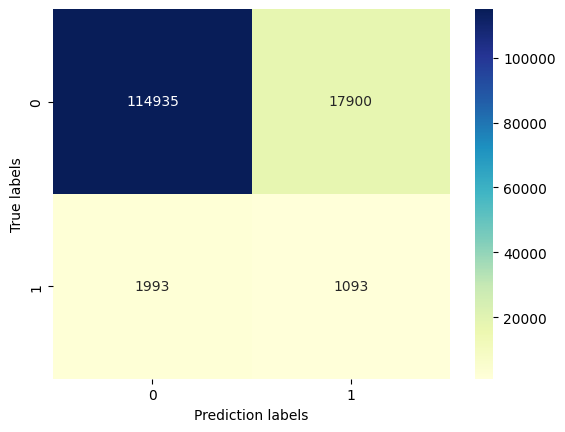

In [1169]:
get_clf_eval(y_val_A, y_pred_A)

정확도: 0.518614
정밀도: 0.047534
재현율: 0.545008
AUC: 0.531228
F1: 0.087442


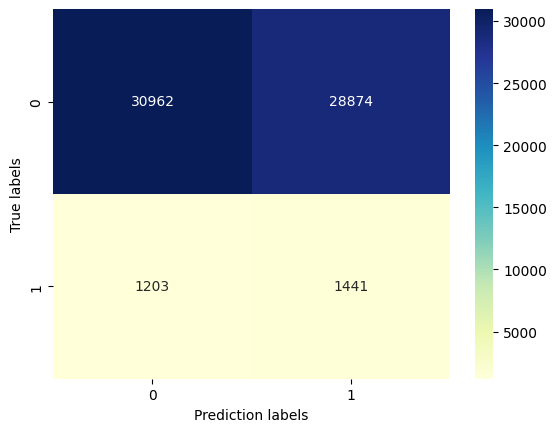

In [1170]:
get_clf_eval(y_val_B, y_pred_B)

In [1171]:
test_pred_A = model_A.predict_proba(df_test_A[target_col])[:,1]
test_pred_B = model_B.predict_proba(df_test_B[target_col_B])[:,1]

In [1172]:
test_pred_A

array([0.41570242, 0.34316638, 0.38115981, ..., 0.40333926, 0.57415274,
       0.42026356], shape=(58252,))

In [1173]:
test_pred_B

array([0.49204093, 0.4808115 , 0.54113224, ..., 0.51411141, 0.49254375,
       0.44390876], shape=(26778,))

In [1174]:
# test_pred_A = (test_pred_A >= best_thr_A).astype(int)
# test_pred_B = (test_pred_B >= best_thr_B).astype(int)

In [1175]:
subA = pd.DataFrame({"Test_id": df_test_A["Test_id"].values, "prob": test_pred_A})
subB = pd.DataFrame({"Test_id": df_test_B["Test_id"].values, "prob": test_pred_B})
probs = pd.concat([subA, subB], axis=0, ignore_index=True)

# ---- sample_submission 기반 결과 생성 (Label 컬럼에 0~1 확률 채움) ----
# os.makedirs(OUT_DIR, exist_ok=True)
# sample = pd.read_csv(SAMPLE_SUB_PATH)
# sample의 Test_id 순서에 맞추어 prob 병합
out = train_meta.merge(probs, on="Test_id", how="left")
out["Label"] = out["prob"].astype(float).fillna(0.0)
out = out.drop(columns=["prob"])


In [1176]:
roc_auc_score(train_meta[train_meta.drop("Test",axis=1).columns[1:]],out[out.drop("Test",axis=1).columns[1:]])

0.50117613724655

In [1177]:
auc_brier_ece(train_meta.drop("Test",axis=1),out.drop("Test",axis=1))

(np.float64(0.50117613724655),
 np.float64(0.047247496879850345),
 np.float64(0.06637176723858973),
 np.float64(0.27781674740633505))

In [1178]:
test_pred_A_ = model_A.predict(df_test_A[target_col])
test_pred_B_ = model_B.predict(df_test_B[target_col_B])

In [1179]:
test_pred_A_

array([0, 0, 0, ..., 0, 1, 0], shape=(58252,))

In [1180]:
test_pred_B_

array([0, 0, 1, ..., 1, 0, 0], shape=(26778,))

정확도: 0.707753
정밀도: 0.041895
재현율: 0.543116
AUC: 0.627346
F1: 0.077790


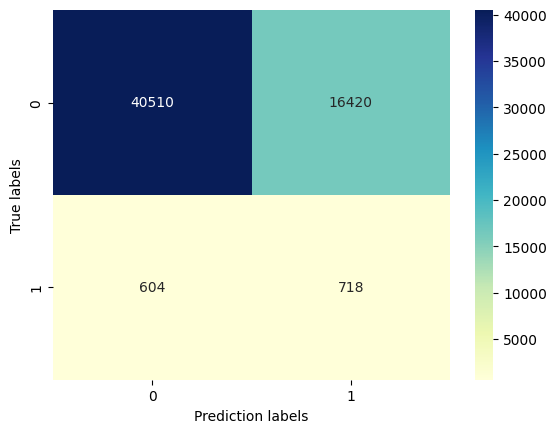

In [1181]:
get_clf_eval(df_test_A["Label"], test_pred_A_)

정확도: 0.594443
정밀도: 0.049718
재현율: 0.473963
AUC: 0.536864
F1: 0.089995


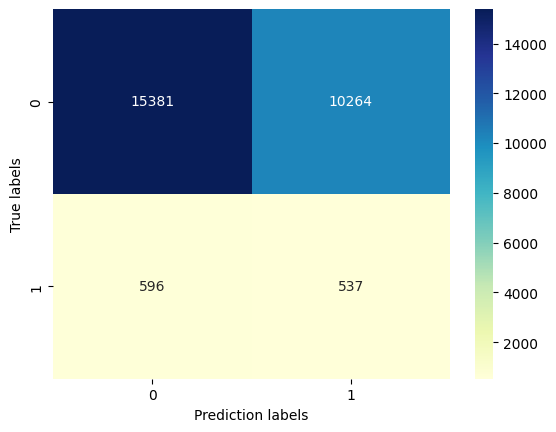

In [1182]:
get_clf_eval(df_test_B["Label"], test_pred_B_)

In [1183]:
pipe_A_ = Pipeline([('prep', preprocess_A), ('model', model_A)])
pipe_B_ = Pipeline([('prep', preprocess_B), ('model', model_B)])

In [1184]:
pipe_A_

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [1185]:
import os
import joblib

# 모델 저장 경로
os.makedirs("./model", exist_ok=True)

joblib.dump(pipe_A_, "./model/model_A_pipeline.joblib")
joblib.dump(pipe_B_, "./model/model_B_pipeline.joblib")   # ★ 통째로 저장

print("모델 저장 완료: ./model/lgbm_A.pkl, ./model/lgbm_B.pkl")

모델 저장 완료: ./model/lgbm_A.pkl, ./model/lgbm_B.pkl


In [1186]:
joblib.dump(target_col, "./model/target_col_A.joblib")
joblib.dump(target_col_B, "./model/target_col_B.joblib")   # ★ 통째로 저장


['./model/target_col_B.joblib']

In [1187]:
pwd

'c:\\Users\\SSAFY\\Downloads\\open'

In [ ]:
0.0002604763431008905
0.0007075310568325222
0.00022502509818878025
0.0014135633828118443
0.10944760590791702
0.0005211815005168319
0.021798744797706604
0.21979956328868866
0.02254953421652317
0.00317776738665998

In [ ]:
0.0017785861855372787
0.0027763848192989826
2.8929198379046284e-05
2.0180244973744266e-05
0.0017288776580244303
3.954762632929487e-06
0.0322246178984642
0.1708998829126358
0.01315577607601881
2.4323146135429852e-05